In [22]:
import pandas as pd
import numpy as np
import os
import numpy
import matplotlib.pyplot as plt
import SimpleITK
import itertools
import sys
import torch
from torchvision import transforms
from PIL import Image

from pathlib import Path

SOURCE_PATH = Path(os.getcwd()) / 'src'

if SOURCE_PATH not in sys.path:
    sys.path.append(SOURCE_PATH)

from src.extraction import (
    get_images_lists_from_path,
    get_images_lists_from_more_paths
)

from src.plots import (
    plot_observation
)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
hgg = Path(os.getcwd()) / 'data' / 'HGG'
lgg = Path(os.getcwd()) / 'data' / 'LGG'

In [24]:
t2, t1ce, t1, flair, seg = get_images_lists_from_path(hgg)
t2l, t1cel, t1l, flairl, segl = get_images_lists_from_path(lgg)

images = [t2, t1, t1ce, flair, seg]
imagesl = [t2l, t1l, t1cel, flairl, segl]
all_images = get_images_lists_from_more_paths([hgg,lgg])

In [29]:
images[0][0].shape

(240, 240)

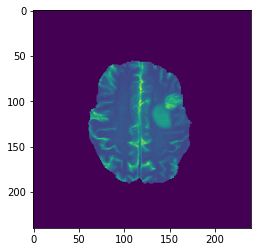

In [27]:
plt.imshow(images[0][0])

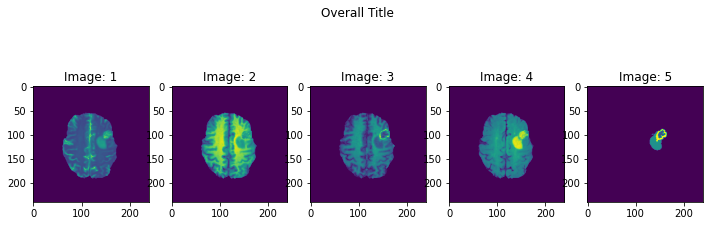

In [4]:
plot_observation(images, 0)

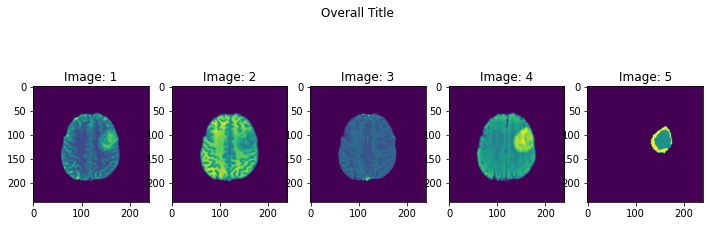

In [5]:
plot_observation(imagesl, 0)

In [7]:
model = torch.hub.load('pytorch/vision', 'deeplabv3_resnet101', pretrained=True)
model.eval()

Downloading: "https://github.com/pytorch/vision/archive/main.zip" to /Users/lorenzo/.cache/torch/hub/main.zip
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /Users/lorenzo/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [03:48<00:00, 1.07MB/s] 


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

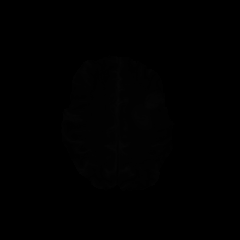

In [26]:
Image.fromarray(images[0][0])

In [ ]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
input_image = PIL.Image.open('image.png')


input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) 

# move the input and model to GPU if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

In [ ]:
with torch.no_grad():
    output = model(input_batch)['out'][0]
output_predictions = output.argmax(0)

# create a color pallette, selecting a color for each class
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

In [ ]:
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision import models

def createDeepLabv3(outputchannels=1):
    """DeepLabv3 class with custom head
    Args:
        outputchannels (int, optional): The number of output channels
        in your dataset masks. Defaults to 1.
    Returns:
        model: Returns the DeepLabv3 model with the ResNet101 backbone.
    """
    model = models.segmentation.deeplabv3_resnet101(pretrained=True,
                                                    progress=True)
    model.classifier = DeepLabHead(2048, outputchannels)
    # Set the model in training mode
    model.train()
    return model

In [ ]:
import torch
from sklearn.metrics import f1_score, roc_auc_score
from torch.utils import data

import datahandler
from model import createDeepLabv3
from trainer import train_model


@click.command()
@click.option("--data-directory",
              required=True,
              help="Specify the data directory.")
@click.option("--exp_directory",
              required=True,
              help="Specify the experiment directory.")
@click.option(
    "--epochs",
    default=25,
    type=int,
    help="Specify the number of epochs you want to run the experiment for.")
@click.option("--batch-size",
              default=4,
              type=int,
              help="Specify the batch size for the dataloader.")
def main(data_directory, exp_directory, epochs, batch_size):
    # Create the deeplabv3 resnet101 model which is pretrained on a subset
    # of COCO train2017, on the 20 categories that are present in the Pascal VOC dataset.
    model = createDeepLabv3()
    model.train()
    data_directory = Path(data_directory)
    # Create the experiment directory if not present
    exp_directory = Path(exp_directory)
    if not exp_directory.exists():
        exp_directory.mkdir()

    # Specify the loss function
    criterion = torch.nn.MSELoss(reduction='mean')
    # Specify the optimizer with a lower learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # Specify the evaluation metrics
    metrics = {'f1_score': f1_score, 'auroc': roc_auc_score}

    # Create the dataloader
    dataloaders = datahandler.get_dataloader_single_folder(
        data_directory, batch_size=batch_size)
    _ = train_model(model,
                    criterion,
                    dataloaders,
                    optimizer,
                    bpath=exp_directory,
                    metrics=metrics,
                    num_epochs=epochs)

    # Save the trained model
    torch.save(model, exp_directory / 'weights.pt')